## Basics

In [1]:
def get_results_for_p(p,all_results):
    # Create the key as a tuple
    #key = (p.num_z,p.num_v,p.num_n,p.n_bar,p.num_q,p.q_0,p.prod_q,p.hire_c,p.k_entry,p.k_f,p.prod_alpha,p.dt)
    key = (p.num_z,p.num_v,p.num_n,p.n_bar,p.num_q,p.q_0,p.prod_q,p.hire_c,p.prod_alpha,p.dt,p.u_bf_m)
    # Check if the key exists in the saved results
    if key in all_results:
        print(key)
        return all_results[key]
    else:
        print(f"No results found for p = {key}")
        return None

from primitives import Parameters
p = Parameters()
import pickle
import matplotlib.pyplot as plt
import numpy as np
from plots import Plots
import cProfile
import pstats

plts=Plots(p)
cc_J,cc_W,cc_Wstar,cc_Jpi,cc_pc,mwc_J,mwc_W,mwc_Wstar,mwc_pc,mwc_n1,mwc_s_J,mwc_s_W,mwc_s_Wstar,mwc_s_sep,mwc_sd_J,mwc_sd_W,mwc_sd_Wstar,mwc_sd_sep=None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None

In [2]:
# Load the temp objects
try:
    with open('my_objects.pkl', 'rb') as file:
        objects = pickle.load(file)
except FileNotFoundError:
    # If the file doesn't exist, start with an empty dictionary
    objects = {}

# Load the permanent results, for sep, across different parametrizations
with open("results_Rho_sep.pkl", "rb") as file:
    all_results = pickle.load(file)
results = get_results_for_p(p,all_results)

No results found for p = (3, 200, 5, 4, 6, 0.5, 0.5, 5.0, 0.5, 0.25, 0.05)


In [3]:
from ContinuousContract import ContinuousContract
cc=ContinuousContract(p)
(cc_J,cc_W,cc_Wstar,cc_Jpi,cc_pc)=cc.J(0)

In [4]:
from Multiworker_Contract_hire_Rho import MultiworkerContract
mwc_Rho=MultiworkerContract(p,cc.js)

In [5]:
mwc_Rho_J = objects['mwc_Rho_J']
mwc_Rho_W = objects['mwc_Rho_W']

profiler = cProfile.Profile()
profiler.enable()
(mwc_Rho_J,mwc_Rho_W,mwc_Rho_Rho,mwc_Rho_Wstar,mwc_Rho_pc,mwc_Rho_n0,mwc_Rho_n1)=mwc_Rho.J()
profiler.disable()
# Print profiling results
stats = pstats.Stats(profiler).sort_stats(pstats.SortKey.TIME)
#stats.print_stats()

objects['mwc_Rho_J'] = mwc_Rho_J
objects['mwc_Rho_W'] = mwc_Rho_W
with open('my_objects.pkl', 'wb') as file:
    pickle.dump(objects, file)

Jshape (3, 5, 5, 200, 6)
W shape (3, 5, 5, 200, 6, 2)
n0_star borders 0.0 3.1274267542725993
Diff Rho: 0.14631227805662303
Errors: 1.8476667532495915e+38 0.06201341801528952 1
n0_star borders 0.0 3.158206162341074
Diff Rho: 9.050146215886116
EJinv -106.62458766706453
EJderiv -47.69107427668301
EJinv diff 1j 2s: 1.3813095774717572
EJinv diff 1 sen: 11.815142400175679
EJinv diff 2 sen: 0.6354504232009319
n0_star borders 0.0 2.2231477841250316
Diff Rho: 14.064208293360453
EJinv -83.30474358269184
EJderiv -60.31059143024767
EJinv diff 1j 2s: 0.6161163169276631
EJinv diff 1 sen: 9.239142413531136
EJinv diff 2 sen: 1.7429684561530643
n0_star borders 0.0 1.717776813999298
Diff Rho: 21.015466975658516
EJinv -78.10239713895669
EJderiv -68.76225919873475
EJinv diff 1j 2s: 3.1873749486327743
EJinv diff 1 sen: 1.8921014029912935
EJinv diff 2 sen: 0.3928539465280409
n0_star borders 0.0 1.6321307398983578
Diff Rho: 20.66290278285181
EJinv -81.8208269166212
EJderiv -76.38542083892332
EJinv diff 1j 2s

In [6]:
if results is None:
    mwc_Rho_s_J = objects['mwc_Rho_s_J']
    mwc_Rho_s_W = objects['mwc_Rho_s_W']
else:
    mwc_Rho_s_J = results['J']
    mwc_Rho_s_W = results['W']

(mwc_Rho_s_J,mwc_Rho_s_W,mwc_Rho_s_Rho,mwc_Rho_s_Wstar,mwc_Rho_s_sep,mwc_Rho_s_n0,mwc_Rho_s_n1)=mwc_Rho.J_sep_dir(mwc_Rho_J,mwc_Rho_W)

objects['mwc_Rho_s_J'] = mwc_Rho_s_J
objects['mwc_Rho_s_W'] = mwc_Rho_s_W
with open('my_objects.pkl', 'wb') as file:
    pickle.dump(objects, file)

Jshape (3, 5, 5, 200, 6)
W shape (3, 5, 5, 200, 6, 2)
q_star [0.5 0.5 0.5 0.5 0.5 0.5]
n0_star borders 0.0 2.206841527097883
Diff Rho: 0.00017052812365170168
Errors: 2.512510219055494e-07 3.107925237563109e-05 1
sep borders 0.0 1.0
q_star [0.5 0.5 0.5 0.5 0.5 0.5]
n0_star borders 0.0 2.2066848276965594
Diff Rho: 0.0004634845538689581
EJinv -1.4871456818792983
EJderiv -0.3187254133566171
EJinv diff 1j 2s: 1.4101031578010652
EJinv diff 1 sen: 2.557832655966407
EJinv diff 2 sen: 0.3020185391174334
sep borders 0.0 1.0
q_star [0.5 0.5 0.5 0.5 0.5 0.5]
n0_star borders 0.0 2.2769057886604256
Diff Rho: 0.000771802871989311
EJinv -1.333137546698112
EJderiv -2.903794853060475
EJinv diff 1j 2s: 0.8748085795127097
EJinv diff 1 sen: 1.2113103240574055
EJinv diff 2 sen: 0.22037181761241334
sep borders 0.0 1.0
q_star [0.5 0.5 0.5 0.5 0.5 0.5]
n0_star borders 0.0 2.3306940097432434
Diff Rho: 0.001044686156451367
EJinv -2.2327982150900234
EJderiv -2.7532708816289073
EJinv diff 1j 2s: 0.4175608323685590

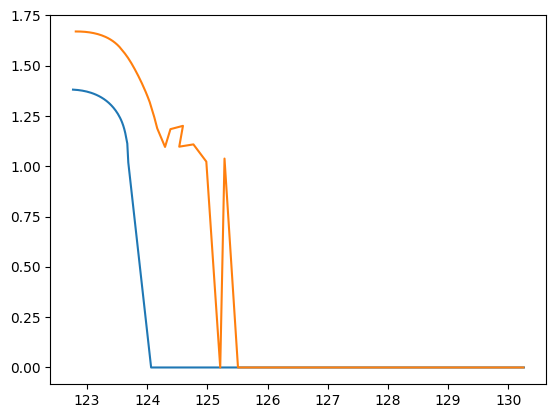

In [7]:
prod = p.z_0-0
j=0
s=1
#plt.plot(mwc_W[p.z_0-1,0,1,:,1],mwc_J[p.z_0-1,0,1,:])
#plt.plot(mwc.w_grid,mwc_n0[p.z_0,0,0,:])
#plt.plot(mwc.w_grid,mwc_W[p.z_0,0,1,:,1])
#plt.plot(mwc_W[p.z_0,0,1,:,1],mwc_n0[p.z_0,0,1,:])
#plt.plot(mwc_W[p.z_0-1,1,1,:,1],mwc_n0[p.z_0-1,1,1,:])
#plt.plot(mwc_Rho_W[p.z_0,0,0,:,5,1],mwc_Rho_n0[p.z_0,0,0,:,5])
plt.plot(mwc_Rho_W[prod,j,s,:,0,1],mwc_Rho_n0[prod,j,s,:,0])
plt.plot(mwc_Rho_s_W[prod,j,s,:,0,1],mwc_Rho_s_n0[prod,j,s,:,0])


#Something is very wrong here, for some reason, when the seniors are the "cheapest" (lowest w_grid), the firm doesn't hire???
#Also the top part is still...kinda weird
#Also no hiring at 1 junior, but hiring at 1 senior???

In [29]:
mwc_Rho.pref.inv_utility(mwc_Rho_W[prod,j,s,199,0,1]*(1-p.beta))

4.505978078657995

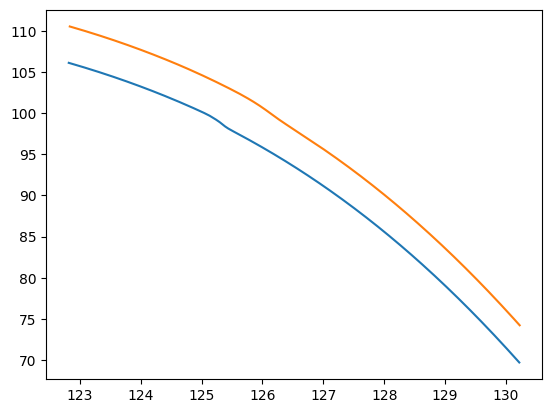

In [8]:
prod = p.z_0-2
j=0
s=1
#plt.plot(mwc_W[p.z_0,j,s,:,1],mwc_J[p.z_0,j,s,:])
#plt.plot(mwc_hmq_W[p.z_0,j,s,:,0,1],mwc_hmq_J[p.z_0,j,s,:,0]-mwc_hmq_J[p.z_0,j-1,s,:,0])
#plt.plot(mwc_Rho_W[p.z_0,j,s,:,0,1],mwc_Rho_J[p.z_0,j,s,:,0]-mwc_Rho_J[p.z_0,j-1,s,:,0])
plt.plot(mwc_Rho_W[prod,j,s,:,0,1],mwc_Rho_J[prod,j,s,:,0])
plt.plot(mwc_Rho_s_W[prod,j,s,:,0,1],mwc_Rho_s_J[prod,j,s,:,0])

#plt.plot(mwc_Rho.w_grid,mwc_Rho_J[prod,j,s,:,0])
#plt.plot(mwc_hmq_W[prod,j,s,:,0,1],mwc_hmq_J[prod,j,s,:,0])
#plt.plot(mwc_Rho_W[p.z_0,j,s,:,0,1],mwc_Rho_n1[p.z_0,j,s,:,0])

In [14]:
import os

In [ ]:
from Multiworker_Contract_all import MultiworkerContract
K=2 #number of tenure levels
mwc=MultiworkerContract(p,cc.js)
(mwc_J,mwc_W,mwc_Wstar,mwc_pc,mwc_n0,mwc_n1)=mwc.J()

So, big question for tomorrow: what the fuck is going on? Why doesn't the firm hire at the lowest worker value???

Same issue here, the value of hiring is initially increasing... for no reason whatsoever

In [7]:
from Multiworker_Contract_GE import MultiworkerContract
mwc_GE=MultiworkerContract(p)

In [ ]:
# GE basic
#mwc_GE_J = objects['mwc_GE_J']
#mwc_GE_W = objects['mwc_GE_W']
mwc_GE_J = objects['mwc_hmq_J']
mwc_GE_W = objects['mwc_hmq_W']


(mwc_GE_J,mwc_GE_W,mwc_GE_Wstar,mwc_GE_sep,mwc_GE_n0,mwc_GE_n1)=mwc_GE.J(mwc_GE_J,mwc_GE_W,0)

objects['mwc_GE_J'] = mwc_GE_J
objects['mwc_GE_W'] = mwc_GE_W
 
with open('my_objects.pkl', 'wb') as file:
    pickle.dump(objects, file)

In [ ]:
# GE separations
if results is None:
    mwc_GE_s_J = objects['mwc_GE_J']
    mwc_GE_s_W = objects['mwc_GE_W']
else:
    mwc_GE_s_J = results['Ji']
    mwc_GE_s_W = results['W1i']

(mwc_GE_s_J,mwc_GE_s_W,mwc_GE_s_Wstar,mwc_GE_s_sep,mwc_GE_s_n0,mwc_GE_s_n1)=mwc_GE.J_sep_dir(mwc_GE_J,mwc_GE_W,1)

objects['mwc_GE_s_J'] = mwc_GE_s_J
objects['mwc_GE_s_W'] = mwc_GE_s_W
 
with open('my_objects.pkl', 'wb') as file:
    pickle.dump(objects, file)

# Plots

In [15]:
output_dir = 'Plots'
if not os.path.exists(output_dir):
         os.makedirs(output_dir)

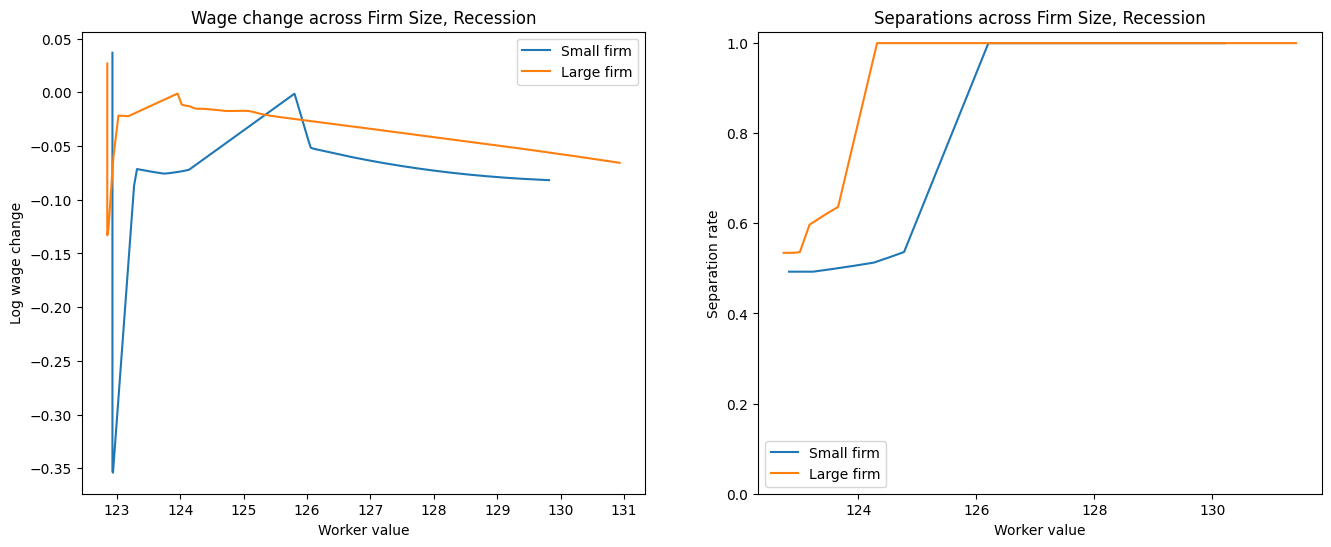

In [16]:
        #THIS IS SOMEHOW THE OPPOSITE??? In firms with many juniors wage drops are larger?? Why?? I guess they don't care for that many seniors?
        #But then why would it equialize afterwards... AHHH BECAUSE ALL THE JUNIORS ARE ALREADY FIRED
        #Now 1,3 places much higher weight on its expensive seniors hencewhy wage drop not that large...? WAGE DROP BOUNCES UP A BIT WHEN THEY START FIRING
        #Still can't understand why 1,1 goes for full firing earlier tho... Also at the same time that complete firing happens, wage drops amplify... guess that makes sense tho
        save=1
        plt.figure(figsize=(16, 6))  # Width=16 inches, Height=6 inches

        # First subplot
        plt.subplot(1, 2, 1) 
        # Plot the data
        #plt.plot(mwc_Rho_s_W[0, 1, 1 ,:, 5, 1], mwc_Rho_s_Wstar[0, 1, 1 ,:, 5]-mwc_Rho_s_W[0, 1, 1 ,:, 5, 1], label='Small firm')
        plt.plot(mwc_Rho_s_Wstar[0, 1, 1 ,:, 5], np.log(np.interp(mwc_Rho_s_Wstar[0, 1, 1 ,:, 5],mwc_Rho_s_W[0,1,1,:,5,1],mwc_Rho.w_grid))-np.log(mwc_Rho.w_grid), label='Small firm')
        plt.plot(mwc_Rho_s_Wstar[0, 1, 3 ,:, 5], np.log(np.interp(mwc_Rho_s_Wstar[0, 1, 3 ,:, 5],mwc_Rho_s_W[0,1,3,:,5,1],mwc_Rho.w_grid))-np.log(mwc_Rho.w_grid), label='Large firm')

        #plt.plot(mwc_Rho_s_W[0, 1, 3 ,:, 5, 1], mwc_Rho_s_Wstar[0, 1, 3 ,:, 5]-mwc_Rho_s_W[0, 1, 3 ,:, 5, 1], label='Larger firm')
        #plt.plot(baseline_W[0, 3, 1 ,:, 5, 1], baseline_Wstar[0, 3, 1 ,:, 5]-baseline_W[0, 3, 1 ,:, 5, 1], label='Larger firm wage')
        #if mwc_s_W is not None:
        #    plt.plot(mwc_s_W[p.z_0-1, 0, 1,:, 1], mwc_s_Wstar[p.z_0-1, 0, 1, :]-mwc_s_W[p.z_0-1, 0, 1,:, 1], label='DRS with separations')
        #if mwc_s_dir_W is not None:
        #    plt.plot(mwc_s_dir_W[p.z_0-1, 0, 1,:, 1], mwc_s_dir_Wstar[p.z_0-1, 0, 1, :]-mwc_s_dir_W[p.z_0-1, 0, 1,:, 1], label='DRS with direct separations')
        plt.legend()
        # Add titles and labels
        plt.title('Wage change across Firm Size, Recession')
        plt.xlabel('Worker value')
        plt.ylabel('Log wage change')

        # Secone subplot
        plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot

        plt.plot(mwc_Rho_s_W[0, 1, 1, :, 0 ,1], mwc_Rho_s_sep[0, 1, 1, :, 0], label='Small firm')
        plt.plot(mwc_Rho_s_W[0, 1, 3, :, 0 ,1], mwc_Rho_s_sep[0, 1, 3, :, 0], label='Large firm')

        plt.legend()
        # Add titles and labels
        plt.title('Separations across Firm Size, Recession')
        plt.xlabel('Worker value')
        plt.ylabel('Separation rate')
        plt.ylim(ymin=0)
        if save==1:
          plt.savefig(os.path.join(output_dir,'Log wage cuts and Separations Across Size.png'), bbox_inches='tight')  # Save as PNG

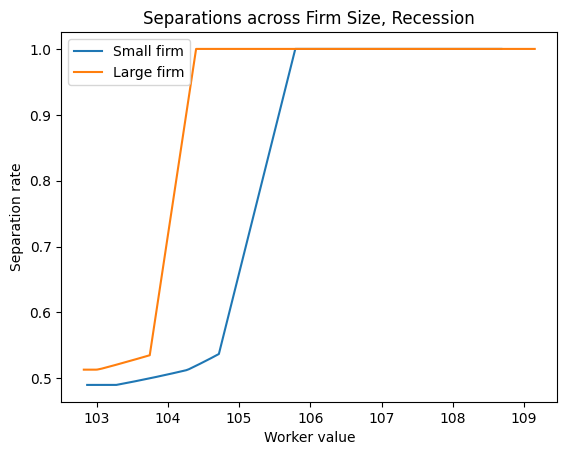

In [28]:

if save==1:
        plt.savefig(os.path.join(output_dir,'Separations Across Size.png'), bbox_inches='tight')  # Save as PNG

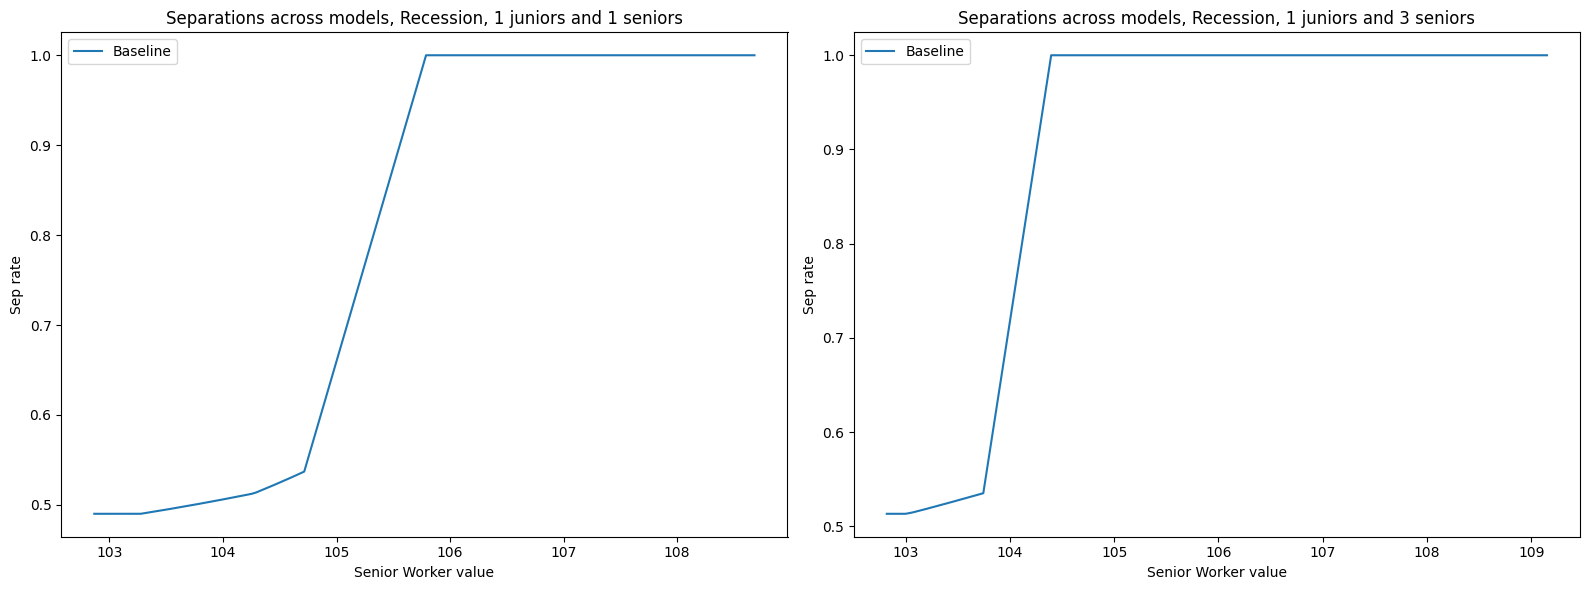

In [14]:
plot_sep(0,0,    1,1,    1,3,    0,  0,0,    0)

In [11]:
def plot_sep(prod1,prod2,jun1,sen1,jun2,sen2,qual,minwage=0,hiresub=0, save=0):       
 
        plt.figure(figsize=(16, 6))  # Width=16 inches, Height=6 inches

        # First subplot
        plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
        prod=prod1
        jun=jun1
        sen=sen1

        #plt.plot(mwc_GE_s_W[prod1, jun, sen, :, qual ,1], mwc_GE_s_sep[prod1, jun, sen, :, qual], label='Baseline')
        plt.plot(mwc_Rho_s_W[prod1, jun, sen, :, qual ,1], mwc_Rho_s_sep[prod1, jun, sen, :, qual], label='Baseline')

     

        if prod1 == 2:
          plt.title(f'Separations across models, Boom, {jun} juniors and {sen} seniors')
        elif prod1 == 0:
          plt.title(f'Separations across models, Recession, {jun} juniors and {sen} seniors')
        else:
          plt.title(f'Separations across models, {prod} productivity, {jun} juniors and {sen} seniors')
        plt.xlabel('Senior Worker value')
        plt.ylabel('Sep rate')
        plt.legend()
        # Second subplot
        plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
        prod=prod2
        jun=jun2
        sen=sen2

        #plt.plot(mwc_GE_s_W[prod2, jun, sen, :, qual ,1], mwc_GE_s_sep[prod2, jun, sen, :, qual], label='Baseline')
        plt.plot(mwc_Rho_s_W[prod2, jun, sen, :, qual ,1], mwc_Rho_s_sep[prod2, jun, sen, :, qual], label='Baseline')
        # Adjust layout to prevent overlap
        if prod2 == 2:
          plt.title(f'Separations across models, Boom, {jun} juniors and {sen} seniors')
        elif prod2 == 0:
          plt.title(f'Separations across models, Recession, {jun} juniors and {sen} seniors')
        else:
          plt.title(f'Separations across models, {prod} productivity, {jun} juniors and {sen} seniors')
        plt.xlabel('Senior Worker value')
        plt.ylabel('Sep rate')
        plt.legend()       
        
        plt.tight_layout()

        if save==1:
          plt.savefig(os.path.join(output_dir,'Separations main 2.png'), bbox_inches='tight')  # Save as PNG

        # Show the plot (optional)
        plt.show()

In [7]:
names = [ 'DRS HMQ', 'DRS HMQ via RHO', 'HMQ']

In [ ]:
plts.CRSvsDRSvalue(names,cc_W,cc_J,mwc_hmq_W[...,0,:],mwc_Rho_J[...,0],mwc_Rho_W[...,0,:],mwc_Rho_J[...,0],None,None,0)

In [9]:
def plot_GE(prod1,prod2,jun1,sen1,jun2,sen2,qual,minwage=0,hiresub=0, save=0):       
 
        plt.figure(figsize=(16, 6))  # Width=16 inches, Height=6 inches

        # First subplot
        plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
        prod=prod1
        jun=jun1
        sen=sen1
       
        plt.plot(mwc_GE_W[prod1, jun, sen, :, qual ,1], mwc_GE_J[prod1, jun, sen, :, qual], label='Baseline')
        if mwc_GE_s_W is not None:
          plt.plot(mwc_GE_s_W[prod1, jun, sen, :, qual ,1], mwc_GE_s_J[prod1, jun, sen, :, qual], label='With separations')


     

        if prod1 == 2:
          plt.title(f'Firm Value, Boom, {jun} juniors and {sen} seniors')
        elif prod1 == 0:
          plt.title(f'Firm Value, Recession, {jun} juniors and {sen} seniors')
        else:
          plt.title(f'Firm Value, {prod} productivity, {jun} juniors and {sen} seniors')
        plt.xlabel('Senior Worker value')
        plt.ylabel('Firm Value')
        plt.legend()
        # Second subplot
        plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
        prod=prod2
        jun=jun2
        sen=sen2
        plt.plot(mwc_GE_W[prod2, jun, sen, :, qual ,1], mwc_GE_J[prod2, jun, sen, :, qual], label='Baseline')
        if mwc_GE_s_W is not None:
          plt.plot(mwc_GE_s_W[prod2, jun, sen, :, qual ,1], mwc_GE_s_J[prod2, jun, sen, :, qual], label='With separations')

       
        # Adjust layout to prevent overlap
        if prod2 == 2:
          plt.title(f'Firm Value, Boom, {jun} juniors and {sen} seniors')
        elif prod2 == 0:
          plt.title(f'Firm Value, Recession, {jun} juniors and {sen} seniors')
        else:
          plt.title(f'Firm Value, {prod} productivity, {jun} juniors and {sen} seniors')
        plt.xlabel('Senior Worker value')
        plt.ylabel('Firm Value')
        plt.legend()       
        
        plt.tight_layout()

        if save==1:
          plt.savefig(os.path.join(output_dir,'General Equilibrium Value Function.png'), bbox_inches='tight')  # Save as PNG

        # Show the plot (optional)
        plt.show()

In [ ]:
plot_GE(2,0,    1,2,    1,1,    0,  0,0,    0)

In [6]:
baseline_sep = objects['baseline_sep']
baseline_W = objects['baseline_W']
baseline_Wstar = objects['baseline_Wstar']


noHMQ_sep = objects['noHMQ_sep']
noHMQ_W = objects['noHMQ_W']
noHMQ_Wstar = objects['noHMQ_Wstar']
nohire_sep = objects['nohire_sep']
nohire_W = objects['nohire_W']
nohire_Wstar = objects['nohire_W']
hiresub_sep = objects['hiresub_sep']
hiresub_W = objects['hiresub_W']
hiresub_Wstar = objects['hiresub_Wstar']

In [7]:
import os
output_dir = 'Plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [8]:
def plott(prod1,prod2,jun1,sen1,jun2,sen2,qual,minwage=0,hiresub=0, save=0):       
 
        plt.figure(figsize=(16, 6))  # Width=16 inches, Height=6 inches

        # First subplot
        plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
        prod=prod1
        jun=jun1
        sen=sen1
        if baseline_W is not None:        
            plt.plot(baseline_W[prod1, jun, sen, 5:50, qual ,1], baseline_sep[prod1, jun, sen, 5:50, qual], label='Baseline')
        plt.plot(mwc_hmq_sd_W[prod1, jun, sen, 5:50, qual ,1], mwc_hmq_sd_sep[prod1, jun, sen, 5:50, qual], label='New baseline')
        if nohire_W is not None:        
         plt.plot(nohire_W[prod1, jun, sen, 5:50, qual ,1], nohire_sep[prod1, jun, sen, 5:50, qual], label='CRS') #Not true CRS but still
        #if noHMQ_W is not None:        
        # plt.plot(noHMQ_W[prod1, jun, sen, 5:50, qual, 1], noHMQ_sep[prod1, jun, sen, 5:50, qual], label='No match heterog')
        #if minwage_W is not None: 
        # if minwage ==1: 
        #  plt.plot(minwage_W[prod1, jun, sen, 5:50, qual, 1], minwage_sep[prod1, jun, sen, 5:50, qual], label='Min wage')
        if hiresub ==1 :
          plt.plot(hiresub_W[prod1, jun, sen, 5:50, qual, 1], hiresub_sep[prod1, jun, sen, 5:50, qual], label='Hiring subsidy')

     

        if prod1 == 2:
          plt.title(f'Separations across models, Boom, {jun} juniors and {sen} seniors')
        elif prod1 == 0:
          plt.title(f'Separations across models, Recession, {jun} juniors and {sen} seniors')
        else:
          plt.title(f'Separations across models, {prod} productivity, {jun} juniors and {sen} seniors')
        plt.xlabel('Senior Worker value')
        plt.ylabel('Sep rate')
        plt.legend()
        # Second subplot
        plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
        prod=prod2
        jun=jun2
        sen=sen2
        if baseline_W is not None:        
            plt.plot(baseline_W[prod2, jun, sen, 5:50, qual, 1], baseline_sep[prod2, jun, sen, 5:50, qual], label='Baseline')
        plt.plot(mwc_hmq_sd_W[prod2, jun, sen, 5:50, qual ,1], mwc_hmq_sd_sep[prod2, jun, sen, 5:50, qual], label='New baseline')
        if nohire_W is not None:        
         plt.plot(nohire_W[prod2, jun, sen, 5:50, qual, 1], nohire_sep[prod2, jun, sen, 5:50, qual], label='CRS')  
        #if noHMQ_W is not None:        
        # plt.plot(noHMQ_W[prod2, jun, sen, 5:50, qual, 1], noHMQ_sep[prod2, jun, sen, 5:50, qual], label='No match heterog')     
        #if minwage_W is not None:
        # if minwage == 1:  
        #  plt.plot(minwage_W[prod2, jun, sen, 5:50, qual, 1], minwage_sep[prod2, jun, sen, 5:50, qual], label='Min wage')
        if hiresub ==1 :
          plt.plot(hiresub_W[prod2, jun, sen, 5:50, qual, 1], hiresub_sep[prod2, jun, sen, 5:50, qual], label='Hiring subsidy')            
        # Adjust layout to prevent overlap
        if prod2 == 2:
          plt.title(f'Separations across models, Boom, {jun} juniors and {sen} seniors')
        elif prod2 == 0:
          plt.title(f'Separations across models, Recession, {jun} juniors and {sen} seniors')
        else:
          plt.title(f'Separations across models, {prod} productivity, {jun} juniors and {sen} seniors')
        plt.xlabel('Senior Worker value')
        plt.ylabel('Sep rate')
        plt.legend()       
        
        plt.tight_layout()

        if save==1:
          plt.savefig(os.path.join(output_dir,'Separations main 2.png'), bbox_inches='tight')  # Save as PNG

        # Show the plot (optional)
        plt.show()

In [ ]:
plott(0,0,  1,3,    2,2,    5,0,0,save=0)

In [ ]:
plott(0,0,  1,1,    1,3,    5, 0,0, save=0)

In [ ]:
        prod2=0
        save=1
        qual = 5
        if baseline_W is not None:        
            plt.plot(baseline_W[prod2, 1, 1, 5:, qual, 1], baseline_sep[prod2, 1, 1, 5:, qual], label='Small firm')
        if baseline_W is not None:        
            plt.plot(baseline_W[prod2, 1, 3, 5:, qual, 1], baseline_sep[prod2, 1, 3, 5:, qual], label='Larger firm')  
        #if baseline_W is not None:        
        
        #plt.plot(baseline_W[prod2, 1, 3, 5:, qual, 1], baseline_sep[prod2, 1, 3, 5:, qual], label='Many seniors')     
         
        # Adjust layout to prevent overlap
        if prod2 == 2:
          plt.title(f'Separations across size, Boom')
        elif prod2 == 0:
          plt.title(f'Separations across size, Recession')
        else:
          plt.title(f'Separations across size, {prod} productivity')
        plt.xlabel('Senior Worker value')
        plt.ylabel('Sep rate')
        plt.legend()       
        
        plt.tight_layout()

        if save==1:
          plt.savefig(os.path.join(output_dir,'Separations across size new.png'), bbox_inches='tight')  # Save as PNG

        # Show the plot (optional)
        plt.show()

In [ ]:
#This is no DRS/hiring. Even less firing than no HMQ

plts.sep(0,p.z_0,1,3,1,3,None,None,noHMQ_W[...,1,:],noHMQ_sep[...,1])

In [ ]:
plts.CRSvsDRSpolicy(cc_W,cc_Wstar,baseline_W[...,0,:],baseline_Wstar[...,0],nohire_W[...,0,:],baseline_Wstar[...,0],None,None,0)

In [ ]:
plts.CRSvsDRSdirect(cc_J,mwc_J,0)

In [ ]:
plts.CRSvsDRSsurplus(cc_J,cc_W,mwc_J,mwc_W,0)

In [ ]:
import matplotlib.pyplot as plt
import os
# Create a directory to save plots
output_dir = 'Plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
            #something like: sep_star = interp(0,foc_sep,sep_grid) + extra conditions
            #need derivatives of future expectations!
            # for that, I interpolate onto rho_star,n0_star, and one of n1_s/q_s. If I'm looking for derivative wrt size, I interpolate onto q_s and THEN take the difference between two discrete values
            #n1_s[iz,in0,in1,iv,iq,s] = (N_grid[in0]*(1-sep_grid[s])+N_grid1[in1]) * pc_temp[iz,in0,in1,iv] #Gives me sep for every damn value hell yeah
            #n1_s_ceil = np.ceil(np.interp( n1_s, N_grid1, range(self.p.num_n))).astype(int)
            #n1_s_floor = np.floor(np.interp( n1_s, N_grid1, range(self.p.num_n))).astype(int)
            #J_n1[iz,...,s,in11] = RegularGridInterpolator((N_grid, rho_grid, Q_grid), EJpi[iz, :, in11, ...], bounds_error=False, fill_value=None) ((n0_star[iz, ...], rho_star[iz, ...], q_s[iz, ...,s]))
            #J_fut_deriv_n[...,s] = (J_n1[...,s,n1_s_ceil[...,s]] - J_n1[...,s,n1_s_floor[...,s]] ) / (N_grid1[n1_s_ceil[...,s]] - N_grid1[n1_s_floor[...,s]]) #This may need a proper loop
            # Boundary check: first_bound = (n1_s_ceil==0), last_bound = (N_grid1[n1_s_floor]==n_bar)
            #J_fut_deriv_n[first_bound] = (J_n1[first_bound,1] - J_n1[first_bound,0] ) / (N_grid1[1] - N_grid1[0])
            #J_fut_deriv_n[last_bound] = (J_n1[last_bound,-1] - J_n1[last_bound,-2] ) / (N_grid1[-1] - N_grid1[-2])
 
            #q_s = (N_grid[self.grid[1]] * (self.p.q_0 - np.max(sep_grid[s]-( 1- self.p.q_0),0))+Q_grid[self.grid[4]]*N_grid1[self.grid[2]]) / (N_grid[self.grid[1]]*(1-sep_grid[s])+N_grid1[self.grid[2]])
            #J_q[iz,...,s,iqq] = RegularGridInterpolator((N_grid, N_grid1, rho_grid), EJpi[iz, ..., iqq], bounds_error=False, fill_value=None) ((n0_star[iz, ...], n1_s[iz,...,s], rho_star[iz, ...]))
            #J_fut_deriv_q[...,s] = (J_q[...,s,q_s_ceil[...,s]] - J_n1  [...,s,q_s_floor[...,s]] ) / (Q_grid[q_s_ceil[...,s]] - Q_grid[q_s_floor[...,s]]) #This may need a proper loop
            # Boundary check: first_bound = (q_s_ceil==0), last_bound = (Q_grid[q_s_floor]=1.0)
            #J_fut_deriv_q[first_bound] = (J_q[first_bound,1] - J_q[first_bound,0] ) / (Q_grid1[1] - Q_grid1[0])
            #J_fut_deriv_q[last_bound] = (J_q[last_bound,-1] - J_q[last_bound,-2] ) / (Q_grid1[-1] - Q_grid1[-2])
            #q_deriv_s = N_grid[grid[1]] * q_s / (N_grid1[grid[2]]+(1-sep_grid[s])*N_grid[grid[1]]) #Probably need to loop over s. Not efficient, but simpler than redoing the whole self.grid thing
            #worker_fut_value = interp ( rho_star,rho_grid,re+EW1i)                    #This is because we don't yet have the worker future value yet. OR just use EW1_star and re_star??? a little risky but possible.
            #Could be a good start
            #foc_sep[...,s] = - J_fut_deriv[...,s] * pc_temp + J_fut_deriv_q * q_deriv_s - (re+EW1i - EUi) / self.pref.inv_utility_1d(self.v_0-self.p.beta*(s_grid[s] * EUi + (1-s_grid[s]) * (EW1_star + re_star)
            # sep_neg = np.all (foc <= 0, axis = -1)
            # sep_max = np.all (foc > 0, axis = -1)
            # sep_star[sep_neg] = 0
            # sep_star[sep_max] = 1.0 #OH SHIT WHAT IF THE Q IS ALREADY AT ITS MAX? I think this should account for it, no?
            #sep_star = interp_multidim(0,-impose_decreasing(foc_sep),sep_grid) 